In [1]:
import gurobipy as gp
import numpy as np
import pandas as pd
from scipy import stats

from gurobi_implementation import GurobiSolution
from data_market import Seller, MarketOperator

#### In this notebook I test the data market with real distributions for solar generation, extracted from Pecan Street data for Austin

In [2]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [3]:
#reading data from csv

probabilities = pd.read_csv('df_probabilities_100.csv')
probabilities = probabilities['0'].to_list()

g_res = pd.read_csv('df_g_res_100.csv')
generation = g_res.drop('Unnamed: 0', axis = 1).loc[0].to_list()

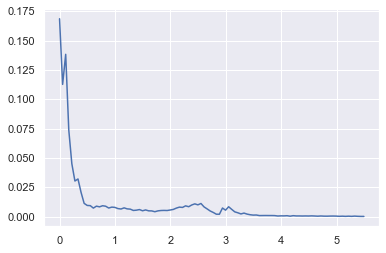

In [4]:
plt.plot(generation, probabilities);

In [5]:
agent_keys = [661, 1642, 2335, 2361, 2818, 3039, 3456, 3538, 4031, 4373, 4767, 5746, 6139, 7536, 7719, 7800, 7901, 7951, 8156, 8386, 8565, 9019, 9160, 9922, 9278]

dataframe_dict = dict()
for key in agent_keys:
    dataframe_dict.update({key : pd.read_csv('/Users/ishilov/Documents/risk_paper/risk_paper/data/df_{}.csv'.format(key))})

community_size = len(dataframe_dict)

for key in agent_keys:
    cond_min = (dataframe_dict[key]['demand'].quantile(0.01) <= dataframe_dict[key]['demand'])
    cond_max = (dataframe_dict[key]['demand'] <= dataframe_dict[key]['demand'].quantile(0.99))
    dataframe_dict[key] = dataframe_dict[key][cond_min & cond_max]

In [6]:
def distribution_build(sample_size, agent_keys):
    res = {}
    
    for key in agent_keys:
        probas_demand, values_demand = np.histogram(dataframe_dict[key]['demand'], bins = sample_size, density=True)
        probas_demand = probas_demand / probas_demand.sum()
        distribution_demand = stats.rv_histogram([probas_demand, values_demand])

        if 'solar' in dataframe_dict[key].columns:
            data = dataframe_dict[key][dataframe_dict[key]['solar'] >= 0]['solar']
            probas_solar, values_solar = np.histogram(data, bins = sample_size, density=True)
            probas_solar = probas_solar / probas_solar.sum()
            distribution_solar = stats.rv_histogram([probas_solar, values_solar])

        res.update({key : 
                    {'probas_demand' : probas_demand,
                    'values_demand' : values_demand,
                    'probas_solar' : probas_solar,
                    'values_solar' : values_solar,
                    'distribution_demand' : distribution_demand,
                    'distribution_solar' : distribution_solar}})

    return res 

In [7]:
def distribution_build_solar(sample_size, agent_keys):
    res = {}
    for key in agent_keys:
        if 'solar' in dataframe_dict[key].columns:
            data = dataframe_dict[key][dataframe_dict[key]['solar'] >= 0]['solar']
            dist = stats.rv_histogram(np.histogram(data, bins = sample_size, density=True))

        res.update({key : dist})

    return res

In [8]:
distributions = distribution_build(300, agent_keys)

In [9]:
distributions_solar = {key : distributions[key]['distribution_solar'] for key in agent_keys}

In [10]:
distributions_solar_2 = distribution_build_solar(300, agent_keys)

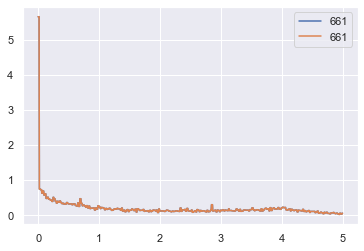

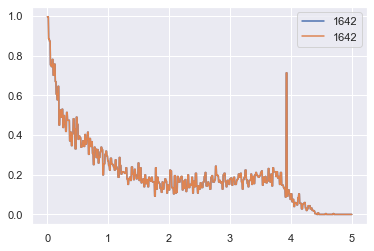

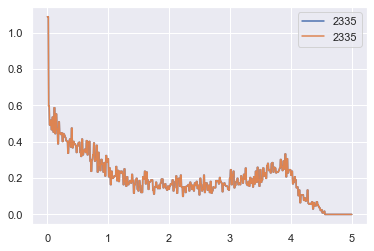

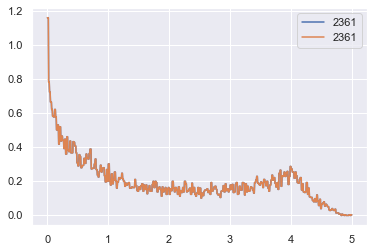

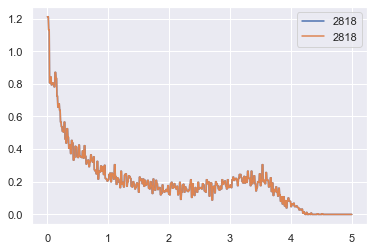

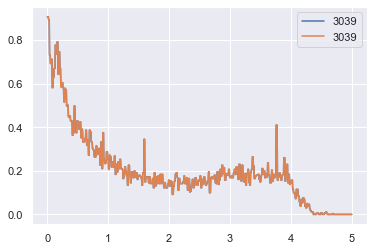

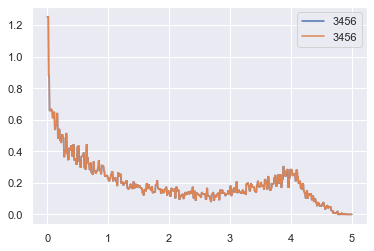

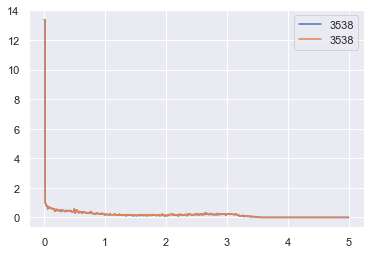

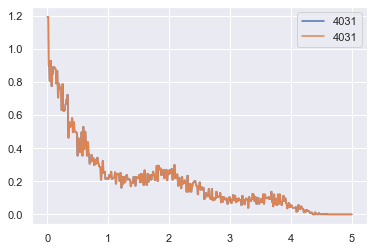

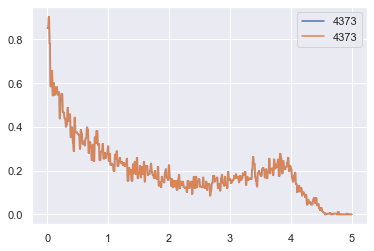

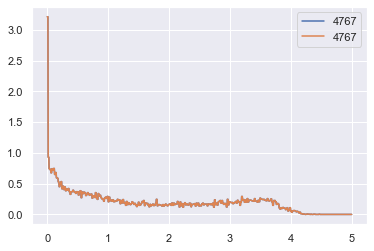

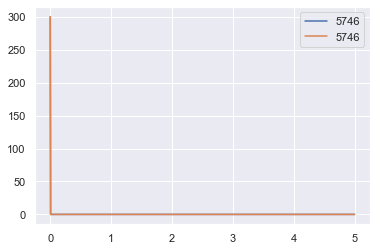

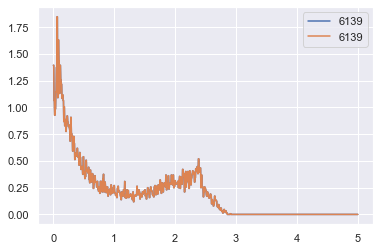

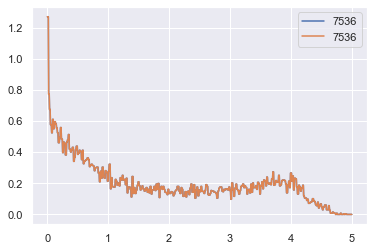

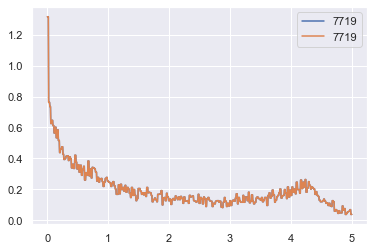

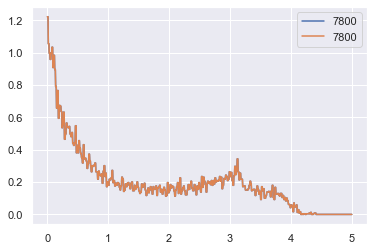

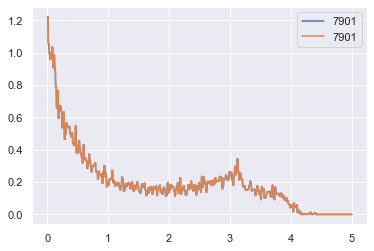

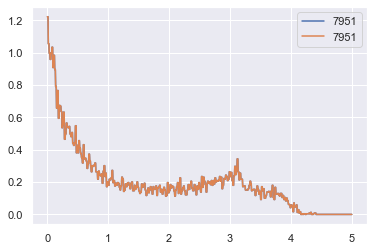

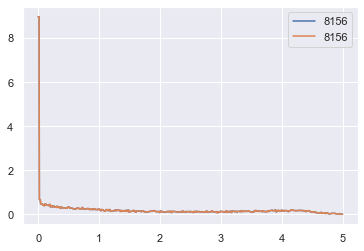

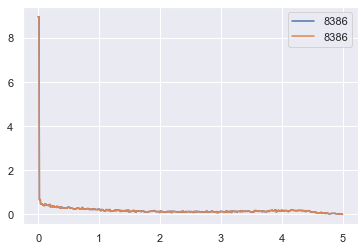

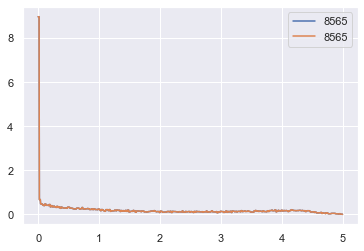

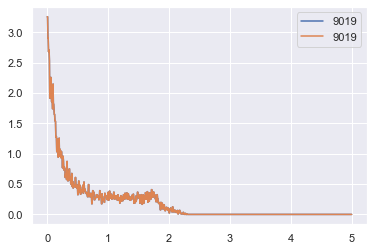

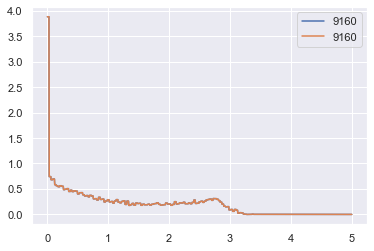

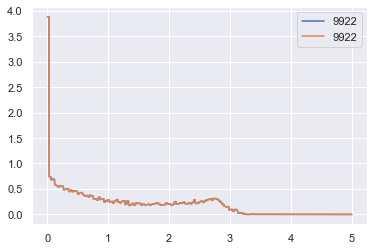

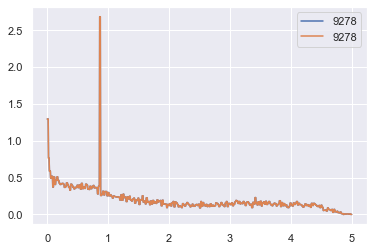

In [11]:
support = np.linspace(0,5, 1000)

for key in agent_keys:
    plt.plot(support, distributions_solar[key].pdf(support), label = key)
    plt.plot(support, distributions_solar_2[key].pdf(support), label = key)
    plt.legend()
    plt.show()

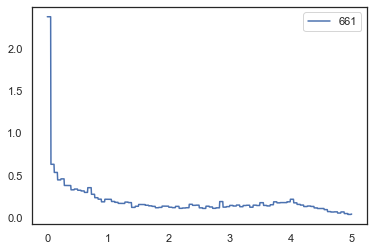

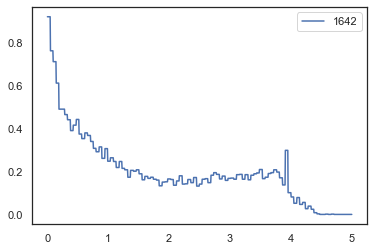

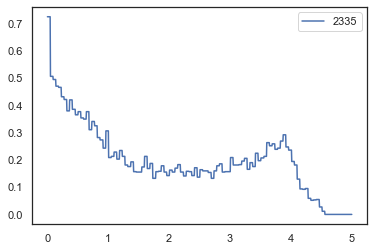

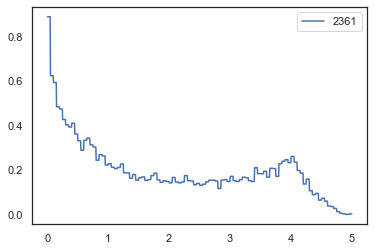

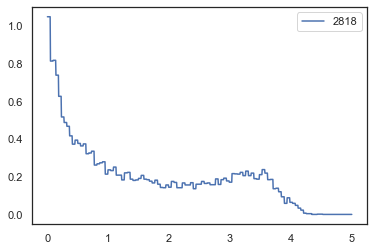

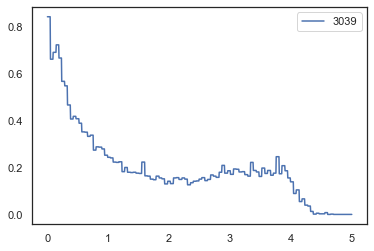

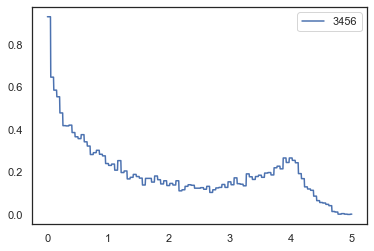

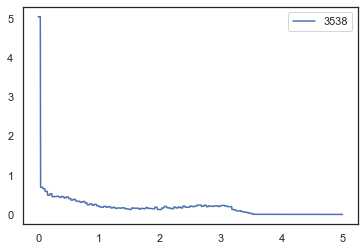

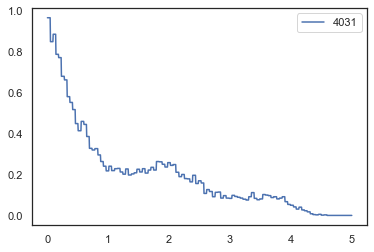

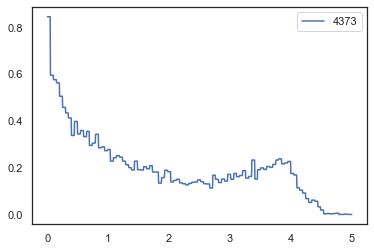

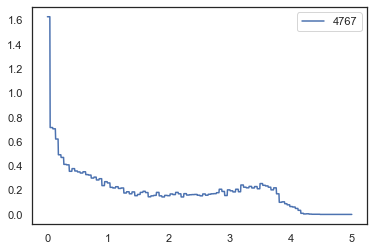

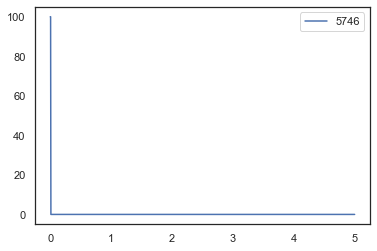

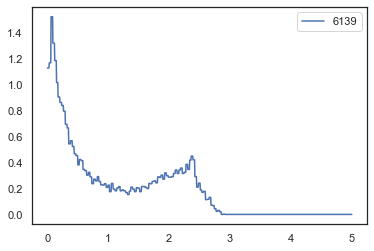

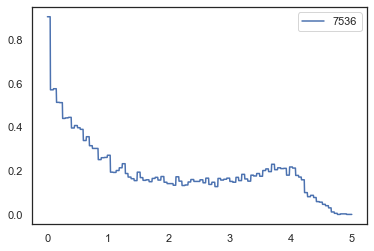

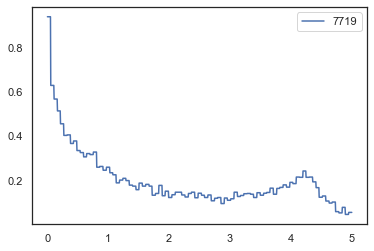

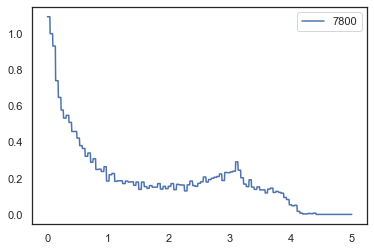

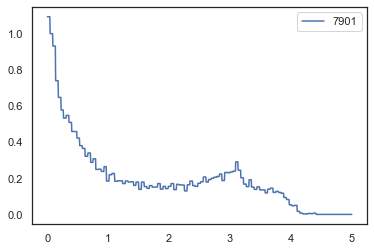

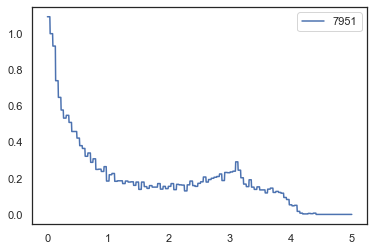

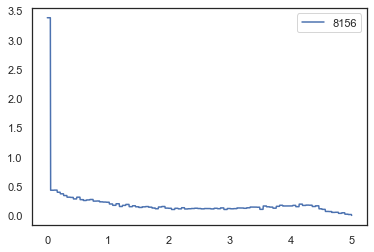

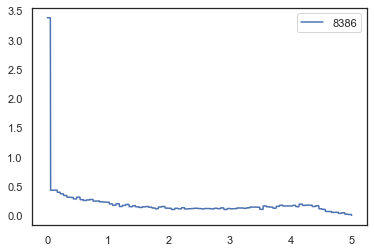

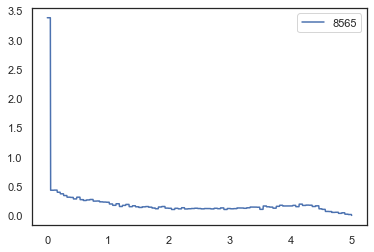

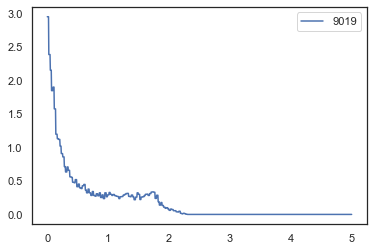

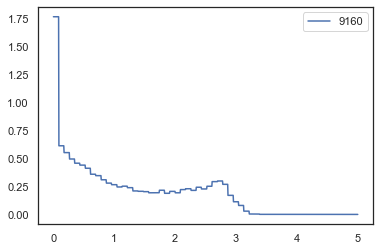

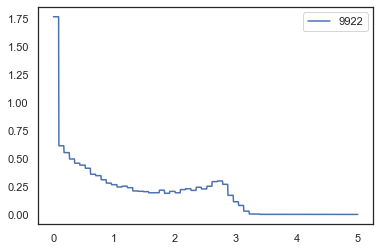

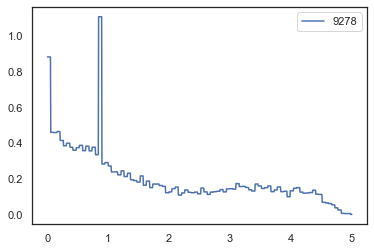

In [153]:
support = np.linspace(0,5, 1000)

for key in agent_keys:
    plt.plot(support, distributions_solar[key].pdf(support), label = key)
    plt.legend()
    plt.show()

In [ ]:
sellers
task = 2